## Installation des Dépendances

In [ ]:
!pip install ultralytics
!pip install yolov5

import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import numpy as np
import logging
from pathlib import Path
from tqdm.notebook import tqdm
import random
import shutil
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from typing import List, Tuple, Dict
from google.colab import drive
import torch.nn.functional as F
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import torch.optim as optim
from collections import defaultdict
import time
from sklearn.manifold import TSNE


from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

### Import du drive du dataset

In [ ]:
drive.mount('/content/drive')


# Chemin vers votre .zip sur Google Drive (VÉRIFIEZ CE CHEMIN)
drive_zip_path = "/content/drive/My Drive/Colab_Backup/celeba_final_train.zip"

local_zip_path = "/content/dataset_clean.zip"
clean_data_dir = "/content/dataset_clean"

print(f"\nCopie de {drive_zip_path} vers {local_zip_path}...")
!cp "{drive_zip_path}" "{local_zip_path}"
print("Copie terminée.")

print(f"Décompression de {local_zip_path} vers {clean_data_dir}...")
os.makedirs(clean_data_dir, exist_ok=True)
!unzip -q "{local_zip_path}" -d "{clean_data_dir}"
print("Décompression terminée.")

In [ ]:
# Chemins
DRIVE_PATH_RAW_SOURCE = "/content/drive/My Drive/classe"
DRIVE_SOURCE_PATH = "/content/drive/My Drive/query_photo"

LOCAL_PATH_RAW = "/content/classe_raw"
LOCAL_DESTINATION_PATH = "/content/query_test_images"

shutil.copytree(DRIVE_PATH_RAW_SOURCE, LOCAL_PATH_RAW)
shutil.copytree(DRIVE_SOURCE_PATH, LOCAL_DESTINATION_PATH)



## ProtoNet

In [ ]:
# =============================================================
#                   PROTO-NET
# =============================================================


%matplotlib inline


def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ==================== MODÈLE ====================

class PretrainedResNet18(nn.Module):
    def __init__(self, feature_dim=128):
        super(PretrainedResNet18, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, feature_dim),
            nn.BatchNorm1d(feature_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x


# ==================== DATASET  ====================

class SimpleFaceDataset:
    def __init__(self, root_dir, split='train', train_ratio=0.8,
                 max_classes=1000, image_size=128):
        self.root_dir = Path(root_dir)
        self.image_size = image_size
        self.yolo_model = YOLO("yolov8n-face.pt")

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        # 1. Lister et mélanger toutes les identités
        all_dirs = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])
        random.seed(42)
        random.shuffle(all_dirs)

        # 2. Calculer l'index de coupure
        num_total = len(all_dirs)
        num_train = int(num_total * train_ratio)

        # 3. Assigner selon le split (train OU test)
        if split == 'train':
            self.selected_dirs = all_dirs[:num_train]
        else:  # test
            self.selected_dirs = all_dirs[num_train:]

        self.data = self._load_dataset()
        self.classes = list(self.data.keys())
        print(f"✓ Split {split.upper()}: {len(self.classes)} identités chargées")


    def _load_dataset(self):
        data = {}
        for class_dir in self.selected_dirs:
            images = []
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                images.extend(class_dir.glob(ext))

            if len(images) >= 15:
                data[class_dir.name] = [str(img) for img in images]
        return data



    def detect_face_with_yolo(self, pil_img):
        try:
            with torch.no_grad():
                results = self.yolo_model(pil_img, verbose=False)

            if results and len(results[0].boxes) > 0:
                box = results[0].boxes[0]
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                return (x1, y1, x2, y2)
        except Exception as e:
            print(f"⚠️ Erreur détection YOLO: {e}")

        return None


    def load_image(self, image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            bbox = self.detect_face_with_yolo(img)
            img = img.crop(bbox)
            return self.transform(img)

        except Exception as e:
            print(f"⚠️ Erreur chargement {image_path}: {e}")
            return torch.zeros(3, self.image_size, self.image_size)


    def sample_task(self, n_way, k_shot, q_query):
        """Échantillonne une tâche few-shot"""
        valid_classes = [cls for cls in self.classes if len(self.data[cls]) >= k_shot + q_query]

        if len(valid_classes) < n_way:
            n_way = len(valid_classes)

        selected_classes = random.sample(valid_classes, n_way)

        support_x, support_y, query_x, query_y = [], [], [], []

        for label, cls in enumerate(selected_classes):
            images = random.sample(self.data[cls], k_shot + q_query)

            # Support set
            for img_path in images[:k_shot]:
                support_x.append(self.load_image(img_path))
                support_y.append(label)

            # Query set
            for img_path in images[k_shot:k_shot + q_query]:
                query_x.append(self.load_image(img_path))
                query_y.append(label)

        return (torch.stack(support_x), torch.tensor(support_y, dtype=torch.long),
                torch.stack(query_x), torch.tensor(query_y, dtype=torch.long))


# ==================== TRAINER  ====================

class AdvancedProtoNetTrainer:
    def __init__(self, encoder, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.encoder = encoder.to(self.device)
        self.optimizer = optim.AdamW(encoder.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        self.criterion = nn.CrossEntropyLoss()

        self.train_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []

    def compute_prototypes(self, support_x, support_y, n_way):
        """Calcule les prototypes pour chaque classe"""
        support_features = self.encoder(support_x)

        prototypes = []
        for c in range(n_way):
            mask = (support_y == c)
            if mask.sum() > 0:
                class_features = support_features[mask]
                prototype = class_features.mean(dim=0)
            else:
                prototype = torch.zeros_like(support_features[0])
            prototypes.append(prototype)

        return torch.stack(prototypes)

    def calculate_loss_acc(self, query_x, query_y, prototypes):
        """Calcule loss et accuracy"""
        query_features = self.encoder(query_x)

        n_query = query_features.shape[0]
        n_way = prototypes.shape[0]

        # Distances euclidiennes
        distances = (
            query_features.unsqueeze(1).expand(n_query, n_way, -1) -
            prototypes.unsqueeze(0).expand(n_query, n_way, -1)
        ).pow(2).sum(dim=2)

        logits = -distances
        loss = self.criterion(logits, query_y)
        predictions = torch.argmin(distances, dim=1)
        accuracy = (predictions == query_y).float().mean().item()

        return loss, accuracy

    def train_epoch(self, dataset, n_way, k_shot, q_query, tasks_per_epoch):
        """Entraînement sur une epoch"""
        self.encoder.train()
        epoch_losses = []
        epoch_accuracies = []

        for _ in range(tasks_per_epoch):
            support_x, support_y, query_x, query_y = dataset.sample_task(n_way, k_shot, q_query)
            support_x = support_x.to(self.device)
            support_y = support_y.to(self.device)
            query_x = query_x.to(self.device)
            query_y = query_y.to(self.device)

            prototypes = self.compute_prototypes(support_x, support_y, n_way)

            # Forward avec gradient
            self.encoder.train()
            loss, accuracy = self.calculate_loss_acc(query_x, query_y, prototypes)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), max_norm=1.0)
            self.optimizer.step()

            epoch_losses.append(loss.item())
            epoch_accuracies.append(accuracy)

        self.scheduler.step()
        current_lr = self.optimizer.param_groups[0]['lr']
        self.learning_rates.append(current_lr)

        avg_loss = np.mean(epoch_losses)
        avg_acc = np.mean(epoch_accuracies)
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(avg_acc)

        return avg_loss, avg_acc, current_lr

    def evaluate(self, dataset, n_way, k_shot, q_query, n_episodes=100):
        """⭐ NOUVELLE FONCTION: Évaluation sur dataset de test"""
        self.encoder.eval()
        accuracies = []

        print(f"\n🧪 Évaluation sur {n_episodes} épisodes ({n_way}-way {k_shot}-shot)...")

        with torch.no_grad():
            for episode in range(n_episodes):
                support_x, support_y, query_x, query_y = dataset.sample_task(
                    n_way, k_shot, q_query
                )
                support_x = support_x.to(self.device)
                support_y = support_y.to(self.device)
                query_x = query_x.to(self.device)
                query_y = query_y.to(self.device)

                prototypes = self.compute_prototypes(support_x, support_y, n_way)
                _, accuracy = self.calculate_loss_acc(query_x, query_y, prototypes)
                accuracies.append(accuracy)

                if (episode + 1) % 20 == 0:
                    print(f"  Episode {episode+1}/{n_episodes}: {np.mean(accuracies[-20:]):.3f}")

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        conf_interval = 1.96 * std_acc / np.sqrt(n_episodes)

        print(f"\n📊 Résultat: {mean_acc:.4f} ± {conf_interval:.4f}")
        return mean_acc, conf_interval


# ==================== FONCTION d'AFFICHAGE ====================

def plot_advanced_results(trainer):
    """Visualisation détaillée des résultats"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    ax1.plot(trainer.train_losses)
    ax1.set_title('Evolution de la Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot([acc * 100 for acc in trainer.train_accuracies], 'orange')
    ax2.axhline(y=5, color='red', linestyle='--', label='Aléatoire (5%)')
    ax2.set_title('Accuracy d\'entraînement')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Learning rate
    ax3.plot(trainer.learning_rates, 'green')
    ax3.set_title('Evolution du Learning Rate')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # Moving average
    if len(trainer.train_accuracies) > 10:
        window = 10
        moving_avg = np.convolve(trainer.train_accuracies, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(trainer.train_accuracies)), [x * 100 for x in moving_avg], 'purple')
        ax4.set_title(f'Accuracy Moyenne (fenêtre {window})')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy (%)')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ==================== FONCTION PRINCIPALE(Orchestre) ====================

def run_advanced_protonet(dataset_path, n_way=5, k_shot=1, q_query=5,
                         num_epochs=100, tasks_per_epoch=50):

    print("="*70)
    print("🚀 PROTO-NET AVEC ÉVALUATION")
    print("="*70)
    print(f"Configuration: {n_way}-way {k_shot}-shot")
    print(f"Query: {q_query} images | Tâches/epoch: {tasks_per_epoch}")
    print("="*70)

    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Device: {device}\n")

    # 1. Charger train, val et test séparément
    print("📂 Chargement des datasets...")
    train_dataset = SimpleFaceDataset(dataset_path, split='train')
    test_dataset = SimpleFaceDataset(dataset_path, split='test')  # Tout le test
    print()

    # 2. Modèle
    print("🏗️  Création du modèle ResNet-18...")
    encoder = PretrainedResNet18(feature_dim=128)
    print(f"✓ Paramètres: {sum(p.numel() for p in encoder.parameters()):,}\n")

    # 3. Trainer
    trainer = AdvancedProtoNetTrainer(encoder, device=device)

    # 4. Entraînement
    print("🚀 Début de l'entraînement ...")
    print("-"*70)

    for epoch in range(num_epochs):
        avg_loss, avg_acc, current_lr = trainer.train_epoch(
            train_dataset, n_way, k_shot, q_query, tasks_per_epoch
        )

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {avg_loss:.4f} | "
                  f"Acc: {avg_acc*100:5.1f}% | LR: {current_lr:.2e}")

    plot_advanced_results(trainer)

    # 5. Évaluation finale sur test
    print("\n" + "="*70)
    print("🎯 ÉVALUATION FINALE SUR TEST SET")
    print("="*70)

    test_results = {}
    scenarios = [
        (5, 1, "5-way 1-shot"),
        (5, 5, "5-way 5-shot"),
        (10, 1, "10-way 1-shot"),
        (10, 5, "10-way 5-shot"),
    ]

    for n_w, k_s, name in scenarios:
        mean_acc, conf  = trainer.evaluate(test_dataset, n_w, k_s, q_query, n_episodes=10)
        test_results[name] = (mean_acc, conf)
        print(f"✅ {name}: {mean_acc*100:.2f}% ± {conf*100:.2f}%")

    return trainer, train_dataset, test_dataset, test_results


🚀 PROTO-NET AVEC ÉVALUATION
Configuration: 20-way 1-shot
Query: 10 images | Tâches/epoch: 50
📱 Device: cuda

📂 Chargement des datasets...
✓ Split TRAIN: 5949 identités chargées
✓ Split TEST: 1468 identités chargées

🏗️  Création du modèle ResNet-18...
✓ Paramètres: 11,242,432

🚀 Début de l'entraînement ...
----------------------------------------------------------------------
Epoch   2/50 | Loss: 2.2069 | Acc:  33.8% | LR: 9.99e-04
Epoch   4/50 | Loss: 2.1085 | Acc:  37.0% | LR: 9.96e-04
Epoch   6/50 | Loss: 2.0614 | Acc:  41.7% | LR: 9.91e-04
Epoch   8/50 | Loss: 2.0390 | Acc:  42.8% | LR: 9.84e-04
Epoch  10/50 | Loss: 1.9925 | Acc:  45.6% | LR: 9.76e-04
Epoch  12/50 | Loss: 1.9724 | Acc:  47.8% | LR: 9.65e-04
Epoch  14/50 | Loss: 1.9783 | Acc:  46.0% | LR: 9.52e-04
Epoch  16/50 | Loss: 1.9268 | Acc:  51.5% | LR: 9.38e-04
Epoch  18/50 | Loss: 1.9066 | Acc:  52.0% | LR: 9.22e-04
Epoch  20/50 | Loss: 1.9191 | Acc:  52.7% | LR: 9.05e-04
Epoch  22/50 | Loss: 1.8899 | Acc:  52.9% | LR: 8.8

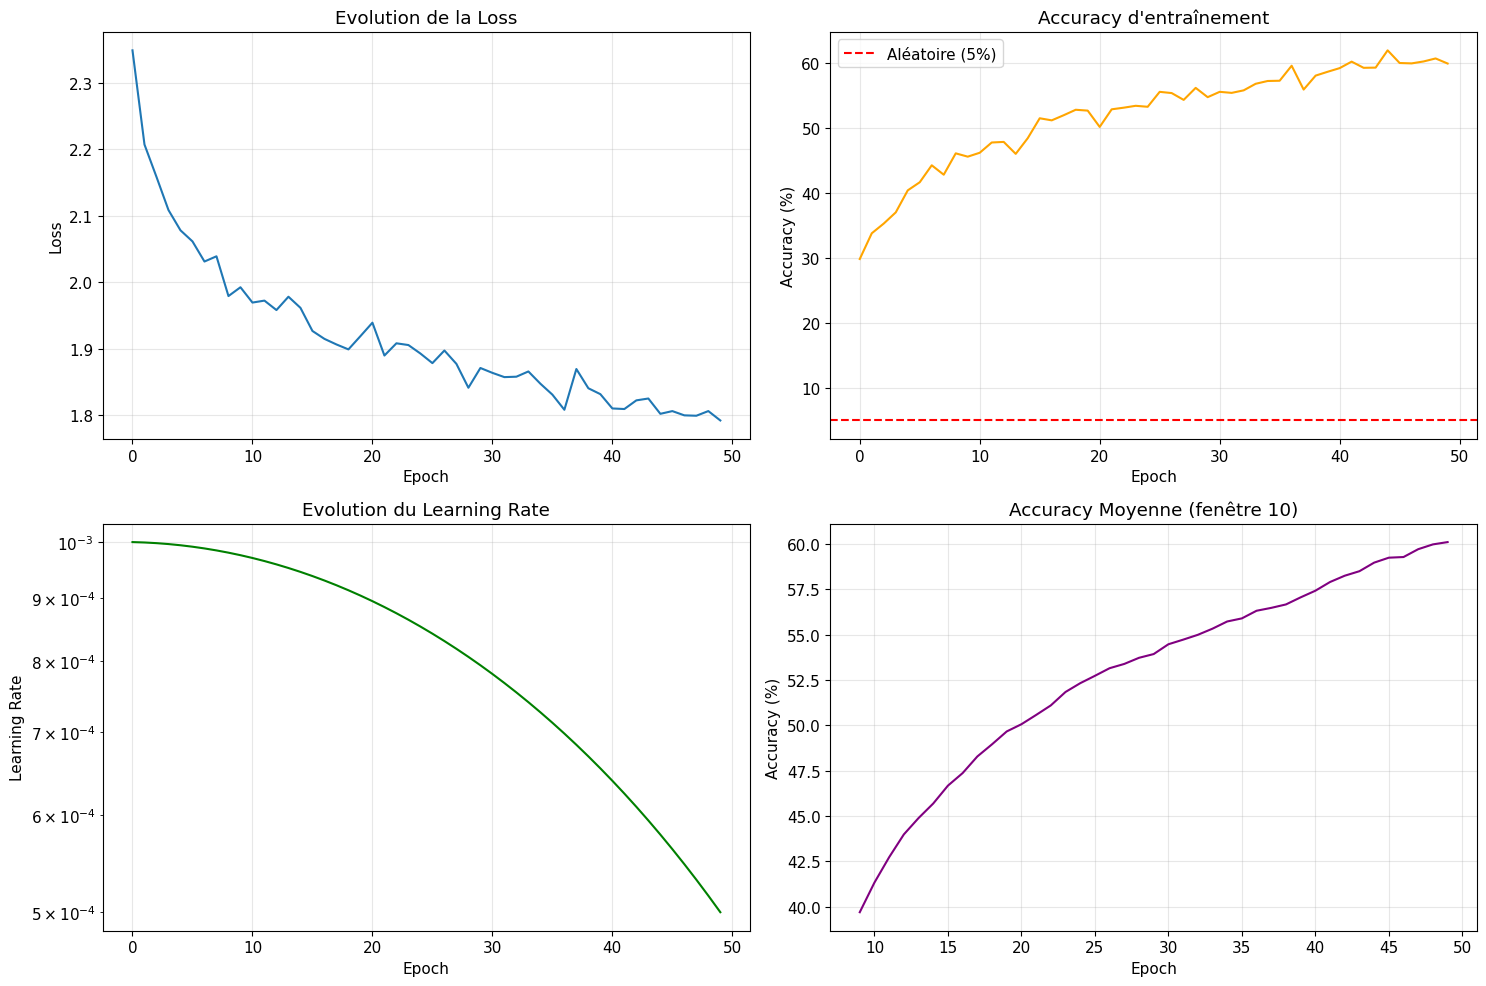


🎯 ÉVALUATION FINALE SUR TEST SET

🧪 Évaluation sur 1 épisodes (5-way 1-shot)...

📊 Résultat: 0.9000 ± 0.0000
✅ 5-way 1-shot: 90.00% ± 0.00%

🧪 Évaluation sur 1 épisodes (5-way 5-shot)...

📊 Résultat: 0.8600 ± 0.0000
✅ 5-way 5-shot: 86.00% ± 0.00%

🧪 Évaluation sur 1 épisodes (10-way 1-shot)...

📊 Résultat: 0.6300 ± 0.0000
✅ 10-way 1-shot: 63.00% ± 0.00%

🧪 Évaluation sur 1 épisodes (10-way 5-shot)...

📊 Résultat: 0.8700 ± 0.0000
✅ 10-way 5-shot: 87.00% ± 0.00%

💾 Sauvegarde du modèle...
✅ Modèle sauvegardé: /content/drive/My Drive/Colab_Backup/protonet_resnet18_splited.pth


In [ ]:
# ==================== LANCEMENT ====================

DATASET_PATH = '/content/dataset_clean/'

trainer, train_dataset , test_dataset , test_results = run_advanced_protonet(
    dataset_path=DATASET_PATH,
    n_way=20,
    k_shot=1,
    q_query=10,
    num_epochs=50,
    tasks_per_epoch=50
    )

# Sauvegarde
print("\n💾 Sauvegarde du modèle...")
save_path = "/content/drive/My Drive/Colab_Backup/protonet_resnet18_splited.pth"
torch.save(trainer.encoder.state_dict(), save_path)
print(f"✅ Modèle sauvegardé: {save_path}")

### ACP 3D

In [ ]:
# ================= 1. CONFIGURATION =================

RAW_FOLDER = '/content/classe_raw'

# Chemins des modèles
MODEL_PATH = "/content/drive/My Drive/Colab_Backup/protonet_resnet18_splited.pth"
YOLO_PATH = "yolov8n-face.pt"


# ================= 2. EXTRACTION DES POSITIONS =================
def get_class_positions(model_path, raw_folder, yolo_model):
    print(f"📍 Calcul des positions pour les images dans : {raw_folder}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Chargement ProtoNet
    model = PretrainedResNet18(feature_dim=128).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except:
        model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.eval()

    # Transfos
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    embeddings = []
    names = []

    folder = Path(raw_folder)
    files = sorted([f for f in folder.iterdir() if f.suffix.lower() in ['.jpg', '.png', '.jpeg']])

    with torch.no_grad():
        for file_path in files:
            person_name = file_path.stem

            # 1. YOLO Crop
            try:
                results = yolo_model(str(file_path), verbose=False)
                if len(results[0].boxes) > 0:
                    boxes = results[0].boxes
                    areas = [(b.xyxy[0][2]-b.xyxy[0][0])*(b.xyxy[0][3]-b.xyxy[0][1]) for b in boxes]
                    best_box = boxes[areas.index(max(areas))]

                    x1, y1, x2, y2 = map(int, best_box.xyxy[0].tolist())

                    # Marge
                    img_full = Image.open(file_path).convert('RGB')
                    margin = 10
                    cx1 = max(0, x1-margin)
                    cy1 = max(0, y1-margin)
                    cx2 = min(img_full.width, x2+margin)
                    cy2 = min(img_full.height, y2+margin)

                    face_img = img_full.crop((cx1, cy1, cx2, cy2))
                else:
                    face_img = Image.open(file_path).convert('RGB')
            except:
                face_img = Image.open(file_path).convert('RGB')

            # 2. Embedding
            img_t = transform(face_img).unsqueeze(0).to(device)
            emb = model(img_t).cpu().numpy().flatten()

            embeddings.append(emb)
            names.append(person_name)
            print(f"   . {person_name}")

    return np.array(embeddings), names

# ================= 3. VISUALISATION 3D ========================
def plot_proximity_map(embeddings, names):
    print("\n🧮 Calcul de l'ACP et de la Variance...")

    pca = PCA(n_components=3)
    components = pca.fit_transform(embeddings)

    # --- CALCUL DE LA VARIANCE ---
    variance_par_axe = pca.explained_variance_ratio_
    total_variance = sum(variance_par_axe) * 100

    print(f"📊 VARIANCE TOTALE EXPLIQUÉE : {total_variance:.2f}%")
    print(f"   ├─ Axe X (Principal) : {variance_par_axe[0]*100:.2f}%")
    print(f"   ├─ Axe Y (Secondaire) : {variance_par_axe[1]*100:.2f}%")
    print(f"   └─ Axe Z (Tertiaire)  : {variance_par_axe[2]*100:.2f}%")

    df = pd.DataFrame(components, columns=['X', 'Y', 'Z'])
    df['Nom'] = names

    print("🚀 Affichage du graphique...")

    fig = px.scatter_3d(
        df,
        x='X', y='Y', z='Z',
        text='Nom',
        color='Nom',
        # On ajoute l'info dans le titre pour l'avoir sous les yeux
        title=f"Carte de Proximité (Variance visible : {total_variance:.1f}%)",
        opacity=0.9,
        size_max=10
    )

    fig.update_layout(
        scene=dict(
            xaxis=dict(showticklabels=False, title=f'X ({variance_par_axe[0]*100:.0f}%)'),
            yaxis=dict(showticklabels=False, title=f'Y ({variance_par_axe[1]*100:.0f}%)'),
            zaxis=dict(showticklabels=False, title=f'Z ({variance_par_axe[2]*100:.0f}%)'),
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

# ================= EXECUTION =================
try:
    yolo = YOLO(YOLO_PATH)
    vecs, labels = get_class_positions(MODEL_PATH, RAW_FOLDER, yolo)
    # Plot
    if len(vecs) > 0:
        plot_proximity_map(vecs, labels)
    else:
        print("❌ Aucune donnée trouvée.")

except Exception as e:
    print(f"❌ Erreur : {e}")

📍 Calcul des positions pour les images dans : /content/classe_raw
   . Ayoub
   . akil (1)
   . akil
   . anthony_ca
   . anthony_s
   . anziza
   . ayoub
   . cedric
   . chamss
   . clement
   . elhadji (1)
   . elhadji
   . enzo_m
   . enzo_n
   . louison
   . lounas
   . lounes
   . luison
   . maximiliano
   . melanie (1)
   . melanie
   . moustapha
   . omia
   . ryan (1)
   . ryan
   . samy
   . sosth (1)
   . sosth
   . thanina
   . yanis
   . youssef

🧮 Calcul de l'ACP et de la Variance...
📊 VARIANCE TOTALE EXPLIQUÉE : 80.96%
   ├─ Axe X (Principal) : 35.88%
   ├─ Axe Y (Secondaire) : 25.82%
   └─ Axe Z (Tertiaire)  : 19.26%
🚀 Affichage du graphique...


### ACP 2D

In [ ]:
# ================= VISUALISATION 2D  =================
def plot_proximity_map(embeddings, names):
    print("\n🧮 Calcul de l'ACP 2D et de la variance expliquée...")

    pca = PCA(n_components=2)
    components = pca.fit_transform(embeddings)

    variance_par_axe = pca.explained_variance_ratio_
    total_variance = np.sum(variance_par_axe) * 100

    print(f"📊 VARIANCE TOTALE EXPLIQUÉE (2D) : {total_variance:.2f}%")
    print(f"   ├─ Axe 1 : {variance_par_axe[0]*100:.2f}%")
    print(f"   └─ Axe 2 : {variance_par_axe[1]*100:.2f}%")

    df = pd.DataFrame(components, columns=['PC1', 'PC2'])
    df['Nom'] = names

    print("🚀 Affichage du graphique 2D...")

    fig = px.scatter(
        df,
        x='PC1',
        y='PC2',
        text='Nom',
        color='Nom',
        title=f"Projection PCA 2D des embeddings ProtoNet (Variance : {total_variance:.1f}%)",
        opacity=0.85
    )

    fig.update_traces(textposition='top center')

    fig.update_layout(
        xaxis=dict(
            title=f'PC1 ({variance_par_axe[0]*100:.1f}%)',
            showticklabels=False
        ),
        yaxis=dict(
            title=f'PC2 ({variance_par_axe[1]*100:.1f}%)',
            showticklabels=False
        ),
        margin=dict(l=40, r=40, b=40, t=60)
    )

    fig.show()

try:
    yolo = YOLO(YOLO_PATH)
    vecs, labels = get_class_positions(MODEL_PATH, RAW_FOLDER, yolo)
    if len(vecs) > 0:
        plot_proximity_map(vecs, labels)
    else:
        print("❌ Aucune donnée trouvée.")

except Exception as e:
    print(f"❌ Erreur : {e}")

📍 Calcul des positions pour les images dans : /content/classe_raw
   . Ayoub
   . akil
   . anthony_ca
   . anthony_s
   . anziza
   . cedric
   . chamss
   . clement
   . elhadji
   . enzo_m
   . enzo_n
   . louison
   . lounas
   . maximiliano
   . melanie
   . moustapha
   . omia
   . ryan
   . samy
   . sosth
   . thanina
   . yanis
   . youssef

🧮 Calcul de l'ACP 2D et de la variance expliquée...
📊 VARIANCE TOTALE EXPLIQUÉE (2D) : 59.24%
   ├─ Axe 1 : 31.83%
   └─ Axe 2 : 27.41%
🚀 Affichage du graphique 2D...


### t-SNE 3D

In [ ]:
def plot_tsne_embeddings_3d_interactive(embeddings, labels):
    """
    Réduit la dimensionnalité (pré-réduction PCA sécurisée + t-SNE)
    et trace la visualisation 3D interactive des clusters d'embeddings avec Plotly.
    """

    n_samples = embeddings.shape[0]

    print(f"🧠 Réduction de dimensionnalité t-SNE pour {n_samples} échantillons (Identités: {len(np.unique(labels))}).")

    # Étape 1: Pré-réduction PCA (sécurisée)
    # n_pca_components doit être < n_samples (31)
    n_pca_components = min(20, n_samples - 1)

    if n_pca_components < 3:
        print("Erreur : Nombre d'échantillons trop faible pour une analyse 3D significative.")
        return

    print(f"   -> Application de la PCA pour pré-réduire à {n_pca_components} dimensions.")
    # On utilise un random_state pour garantir la reproductibilité
    pca_reduced = PCA(n_components=n_pca_components, random_state=42).fit_transform(embeddings)

    # Étape 2: Exécuter t-SNE pour la projection 3D (n_components=3)
    print("   -> Projection 3D finale via t-SNE.")
    # Perplexity 10 est conservée, car elle est appropriée pour n_samples = 31
    tsne = TSNE(n_components=3, random_state=42, perplexity=10, n_iter=500)
    low_dim_data = tsne.fit_transform(pca_reduced)

    # --- Tracé du Graphique 3D avec Plotly ---

    # Créer un DataFrame pour Plotly
    df = pd.DataFrame({
        'tSNE-1': low_dim_data[:, 0],
        'tSNE-2': low_dim_data[:, 1],
        'tSNE-3': low_dim_data[:, 2],
        'Identité': labels
    })

    fig = px.scatter_3d(df,
                        x='tSNE-1',
                        y='tSNE-2',
                        z='tSNE-3',
                        color='Identité',
                        #text='Identité',
                        hover_data={'Identité': False, 'tSNE-1': ':.2f', 'tSNE-2': ':.2f', 'tSNE-3': ':.2f'}, # Désactiver l'identité dans le hover pour éviter la redondance
                        title='Visualisation t-SNE '
                       )

    # Ajustement de la taille du texte pour qu'il soit lisible
    fig.update_traces(textposition='middle right', marker=dict(size=4))

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=40),
        legend_title_text='Identités'
    )

    fig.show()


plot_tsne_embeddings_3d_interactive(vecs, labels)
print("\nAnalyse de l'espace latent t-SNE 3D interactive terminée.")


🧠 Réduction de dimensionnalité t-SNE pour 31 échantillons (Identités: 31).
   -> Application de la PCA pour pré-réduire à 20 dimensions.
   -> Projection 3D finale via t-SNE.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.




Analyse de l'espace latent t-SNE 3D interactive terminée.


### t-SNE 2D

In [ ]:
def plot_tsne_embeddings_2d(embeddings, labels):

    n_samples = embeddings.shape[0]
    print(f"🧠 t-SNE 2D pour {n_samples} échantillons "
          f"({len(np.unique(labels))} identités).")

    # ===================== PCA (pré-réduction obligatoire) =====================
    n_pca_components = min(20, n_samples - 1)

    if n_pca_components < 2:
        print("❌ Trop peu d'échantillons pour t-SNE 2D.")
        return

    print(f"   → Pré-réduction PCA à {n_pca_components} dimensions.")
    pca_embeddings = PCA(
        n_components=n_pca_components,
        random_state=42
    ).fit_transform(embeddings)

    # ===================== t-SNE 2D =====================
    print("   → Projection finale t-SNE 2D.")
    tsne = TSNE(
        n_components=2,
        perplexity=10,
        n_iter=500,
        random_state=42,
        init='pca',
        learning_rate='auto'
    )

    tsne_embeddings = tsne.fit_transform(pca_embeddings)

    # ===================== VISUALISATION =====================
    df = pd.DataFrame({
        't-SNE 1': tsne_embeddings[:, 0],
        't-SNE 2': tsne_embeddings[:, 1],
        'Identité': labels
    })

    fig = px.scatter(
        df,
        x='t-SNE 1',
        y='t-SNE 2',
        color='Identité',
        title='Projection t-SNE 2D de l’espace d’embedding',
        opacity=0.85
    )

    fig.update_traces(marker=dict(size=12))

    fig.update_layout(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        legend_title_text='Identités',
        margin=dict(l=40, r=40, b=40, t=60)
    )

    fig.show()
plot_tsne_embeddings_2d(vecs, labels)

🧠 t-SNE 2D pour 23 échantillons (23 identités).
   → Pré-réduction PCA à 20 dimensions.
   → Projection finale t-SNE 2D.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



## Test sur les images de classe

In [ ]:
# ==================== 1. SYSTÈME DE RECONNAISSANCE ====================
class FaceRecognitionSystem:
    def __init__(self, encoder_path, yolo_model_path, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Initialisation sur : {self.device}")

        # Chargement YOLO
        print("   [1/3] Chargement de YOLO...")
        self.yolo = YOLO(yolo_model_path)

        # Chargement ProtoNet
        print("   [2/3] Chargement de ProtoNet (ResNet18)...")
        self.encoder = PretrainedResNet18(feature_dim=128).to(self.device)

        try:
            state_dict = torch.load(encoder_path, map_location=self.device)
            self.encoder.load_state_dict(state_dict)
            self.encoder.eval()
            print("   ✅ Poids chargés avec succès !")
        except Exception as e:
            print(f"❌ ERREUR CRITIQUE : {e}")
            raise e

        self.database = {}
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print("   [3/3] Système prêt.")

    def _get_embedding(self, img_crop):
        img_tensor = self.transform(img_crop).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.encoder(img_tensor)
        return embedding

    def enroll_users(self, folder_path):
        print(f"\n📂 Démarrage de l'Enrôlement depuis : {folder_path}")
        folder = Path(folder_path)
        extensions = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
        image_files = [f for f in folder.iterdir() if f.suffix.lower() in extensions]
        image_files.sort()

        print(f"   ℹ️  {len(image_files)} images trouvées.")
        success_count = 0

        for img_path in image_files:
            person_name = img_path.stem
            try:
                results = self.yolo(str(img_path), verbose=False)
                if len(results[0].boxes) == 0:
                    print(f"   ⚠️  {person_name}: Pas de visage détecté")
                    continue

                boxes = results[0].boxes
                areas = [(b.xyxy[0][2]-b.xyxy[0][0])*(b.xyxy[0][3]-b.xyxy[0][1]) for b in boxes]
                best_box = boxes[areas.index(max(areas))]

                # Crop avec marge
                img_pil = Image.open(img_path).convert('RGB')
                x1, y1, x2, y2 = map(int, best_box.xyxy[0].tolist())
                margin = 10
                x1, y1, x2, y2 = max(0, x1-margin), max(0, y1-margin), min(img_pil.width, x2+margin), min(img_pil.height, y2+margin)

                face_crop = img_pil.crop((x1, y1, x2, y2))

                # Embedding
                vector = self._get_embedding(face_crop)
                self.database[person_name] = vector
                success_count += 1
                print(f"   ✅ {person_name:15s} : OK")

            except Exception as e:
                print(f"   ❌ Erreur sur {person_name}: {e}")

        print(f"\n🎉 Base terminée : {success_count} enregistrés.")


    def recognize_image(self, test_image_path, threshold=1.0, output_path="resultat.jpg"):
        print(f"\n📸 DIAGNOSTIC APPROFONDI sur : {test_image_path}")

        results = self.yolo.predict(test_image_path)
        if len(results[0].boxes) == 0:
            print("   ⚠️ Aucun visage trouvé.")
            return

        img_cv = cv2.imread(test_image_path)
        img_pil = Image.open(test_image_path).convert('RGB')

        for box in results[0].boxes:
            # 1. Crop du visage
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            margin = 10
            cx1, cy1, cx2, cy2 = max(0, x1-margin), max(0, y1-margin), min(img_pil.width, x2+margin), min(img_pil.height, y2+margin)
            face_crop = img_pil.crop((cx1, cy1, cx2, cy2))


            # 2. Embedding
            query_vec = self._get_embedding(face_crop)

            # 3. Calcul de TOUTES les distances
            distances = [] # Liste de tuples (Nom, Distance)

            for name, ref_vec in self.database.items():
                dist = torch.dist(query_vec, ref_vec).item()
                distances.append((name, dist))

            # 4. Tri du plus proche au plus loin
            distances.sort(key=lambda x: x[1]) # Tri par distance croissante

            # 5. Affichage du TOP 5 (Le diagnostic clé)
            print("\n   --- 🏆 CLASSEMENT DES RESSEMBLANCES ---")
            best_name, best_dist = distances[0]

            for i, (name, dist) in enumerate(distances[:5]):
                marker = "👈 (Faux Positif?)" if i == 0 else ""
                print(f"   #{i+1} : {name:15s} | Distance: {dist:.4f} {marker}")

            # Logique de seuil habituelle pour l'affichage
            final_name = best_name if best_dist < threshold else "Inconnu"

            # Dessin
            color = (0, 255, 0)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv, f"{final_name} ({best_dist:.2f})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

        cv2.imwrite(output_path, img_cv)
        print(f"\n✅ Image sauvegardée : {output_path}")

# ==================== 3. EXÉCUTION ====================

# Vos chemins (Vérifiez qu'ils sont corrects)
PROTONET_MODEL = "/content/drive/My Drive/Colab_Backup/protonet_resnet18_splited.pth"
YOLO_MODEL = "yolov8n-face.pt"
FOLDER_CLASSE_RAW = "/content/classe_raw"
IMAGE_A_TESTER = "/content/query_test_images/33.png"

if __name__ == "__main__":
    try:
        system = FaceRecognitionSystem(PROTONET_MODEL, YOLO_MODEL)
        system.enroll_users(FOLDER_CLASSE_RAW)
        if len(system.database) > 0:
            system.recognize_image(IMAGE_A_TESTER, threshold=1, output_path="resultat_final.jpg")
        else:
            print("❌ Base vide.")
    except Exception as e:
        print(f"❌ Erreur : {e}")

📱 Initialisation sur : cpu
   [1/3] Chargement de YOLO...
   [2/3] Chargement de ProtoNet (ResNet18)...
   ✅ Poids chargés avec succès !
   [3/3] Système prêt.

📂 Démarrage de l'Enrôlement depuis : /content/classe_raw
   ℹ️  21 images trouvées.
   ✅ akil            : OK
   ✅ anthony_ca      : OK
   ✅ anthony_s       : OK
   ✅ anziza          : OK
   ✅ ayoub           : OK
   ✅ cedric          : OK
   ✅ chamss          : OK
   ✅ clement         : OK
   ✅ elhadji         : OK
   ✅ enzo_m          : OK
   ✅ enzo_n          : OK
   ✅ louison         : OK
   ✅ lounas          : OK
   ✅ maximiliano     : OK
   ✅ melanie         : OK
   ✅ moustapha       : OK
   ✅ omia            : OK
   ✅ ryan            : OK
   ✅ samy            : OK
   ✅ sosth           : OK
   ✅ yanis           : OK

🎉 Base terminée : 21 enregistrés.

📸 DIAGNOSTIC APPROFONDI sur : /content/query_test_images/33.png

   --- 🏆 CLASSEMENT DES RESSEMBLANCES ---
   #1 : enzo_m          | Distance: 0.4689 👈 (Faux Positif?)
   #2

### AUC

In [ ]:
def get_test_set_from_folder(folder_path):
    """
    Crée la liste des images de test (chemin, nom_reel) en supposant que
    le nom de fichier contient le nom de l'étudiant (ex: 'ryan_test.jpg' -> 'ryan').
    """
    print(f"\n📂 Chargement du jeu de test AUC depuis : {folder_path}")
    test_set = []
    folder = Path(folder_path)

    for img_path in folder.iterdir():
        if img_path.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            try:
                true_name = img_path.stem.split('_')[0].lower()
                test_set.append((str(img_path), true_name))
            except Exception:
                print(f"   ⚠️ Impossible de déterminer le nom pour {img_path.name}. Ignoré.")
                continue

    print(f"   ✅ {len(test_set)} images de test chargées.")
    return test_set


def calculate_biometric_metrics(system, test_set):
    """
    Calcule l'AUC et l'EER en utilisant les requêtes (test_set)
    et leur distance à tous les prototypes (system.database).
    """
    distances_scores = []
    binary_labels = []

    prototype_names = list(system.database.keys())
    prototype_vectors = torch.cat(list(system.database.values())).squeeze(1)

    print("\n" + "=" * 50)
    print(f"🎯 Démarrage de l'évaluation biométrique sur {len(test_set)} images test...")

    for i, (test_path, true_name) in enumerate(test_set):

        if true_name not in system.database:
            print(f"   ⚠️ {true_name} n'est pas dans la base de données. Ignoré.")
            continue

        results = system.yolo.predict(test_path, verbose=False)
        if len(results[0].boxes) == 0:
            continue

        box = results[0].boxes[0]
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

        img_pil = Image.open(test_path).convert('RGB')
        margin = 10
        cx1, cy1, cx2, cy2 = max(0, x1-margin), max(0, y1-margin), min(img_pil.width, x2+margin), min(img_pil.height, y2+margin)
        face_crop = img_pil.crop((cx1, cy1, cx2, cy2))
        query_vec = system._get_embedding(face_crop)

        # Calculer la distance de la requête à TOUS les prototypes
        query_repeated = query_vec.repeat(len(prototype_vectors), 1)
        all_dists = torch.linalg.norm(query_repeated - prototype_vectors, dim=1).cpu().numpy()

        # Remplissage des listes de scores et de labels
        for k, dist in enumerate(all_dists):
            distances_scores.append(dist)

            if prototype_names[k] == true_name:
                binary_labels.append(1) # Paire Positive
            else:
                binary_labels.append(0) # Paire Négative

    # Conversion en numpy array
    distances_scores = np.array(distances_scores)
    binary_labels = np.array(binary_labels)

    if len(distances_scores) == 0:
        print("❌ Aucune paire générée. Veuillez vérifier les chemins/noms.")
        return 0.0, 1.0, 0.0

    # --- Calcul de l'AUC et de l'EER ---
    max_distance = np.max(distances_scores)
    # L'inversion est nécessaire pour que roc_curve interprète l'augmentation du score comme une acceptation
    similarity_scores = max_distance - distances_scores

    fpr, tpr, thresholds = roc_curve(binary_labels, similarity_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    fnr = 1 - tpr
    # Calcul de l'EER (point où FRR = FPR)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # Trouver le Seuil Optimal (τ)
    eer_threshold_index = np.argmin(np.abs(fnr - fpr))
    eer_threshold = max_distance - thresholds[eer_threshold_index]

    print(f"   Nombre total de paires générées : {len(distances_scores)}")
    print(f"   AUC (Aire Sous la Courbe ROC) : {roc_auc:.4f}")
    print(f"   EER (Taux d'Erreur Égale) : {eer*100:.2f}%")
    print(f"   Seuil Optimal (τ) à l'EER : {eer_threshold:.4f}")
    print("=" * 50)

    return roc_auc, eer, eer_threshold, fpr, tpr, max_distance

def plot_roc_curve(fpr, tpr, roc_auc, eer, eer_threshold, max_distance):
    """Trace la courbe ROC et marque l'EER."""

    # Trouver le seuil à l'EER dans le score de similarité
    eer_similarity_threshold = max_distance - eer_threshold

    plt.figure(figsize=(8, 6))

    # 1. Tracé de la courbe ROC
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'Courbe ROC du ProtoNet (AUC = {roc_auc:.4f})')

    # 2. Tracé de la ligne aléatoire (chance)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.6, label='Aléatoire (AUC=0.5)')

    # 3. Marquage de l'EER
    # L'EER est le point où FPR = FRR (1-TPR)
    plt.plot([eer, eer], [eer, 1-eer], 'r:', label=f'EER = {eer*100:.2f}%') # Ligne verticale
    plt.plot([eer, 1-eer], [eer, eer], 'r:') # Ligne horizontale (pour visualiser l'intersection)
    plt.scatter(eer, 1 - eer, color='red', s=50, zorder=5, label=f'EER (Seuil={eer_threshold:.4f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC du Système de Reconnaissance (AUC et EER)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()


📂 Chargement du jeu de test AUC depuis : /content/AUC
   ✅ 9 images de test chargées.

🎯 Démarrage de l'évaluation biométrique sur 9 images test...
   ⚠️ anthony n'est pas dans la base de données. Ignoré.
   Nombre total de paires générées : 168
   AUC (Aire Sous la Courbe ROC) : 0.8547
   EER (Taux d'Erreur Égale) : 25.00%
   Seuil Optimal (τ) à l'EER : 0.9511


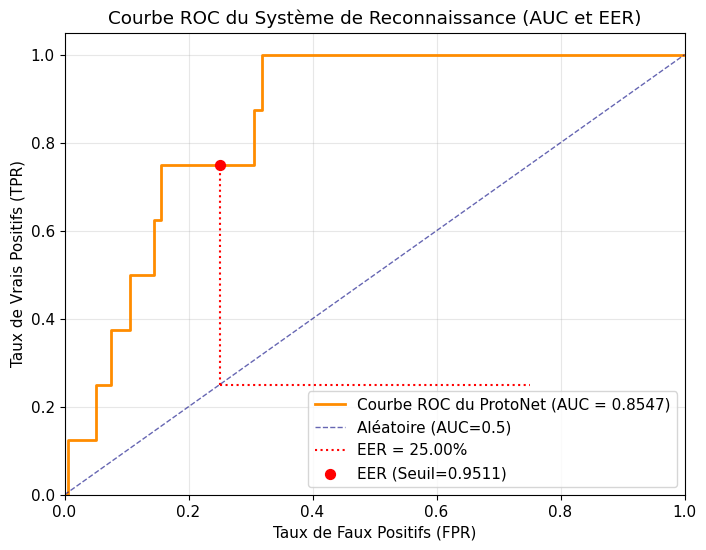


Le Seuil de décision optimal à utiliser est : 0.9511


In [ ]:
FOLDER_AUC_TEST = "/content/AUC"


if __name__ == "__main__":
    try:

        if len(system.database) > 0:

            test_set_auc = get_test_set_from_folder(FOLDER_AUC_TEST)

            if len(test_set_auc) > 0:
                (auc_score, eer_rate, optimal_threshold,
                 fpr_data, tpr_data, max_dist) = calculate_biometric_metrics(system, test_set_auc)
                plot_roc_curve(fpr_data, tpr_data, auc_score, eer_rate, optimal_threshold, max_dist)

                print(f"\nLe Seuil de décision optimal à utiliser est : {optimal_threshold:.4f}")
        else:
            print("❌ Base vide.")
    except Exception as e:
        print(f"❌ Erreur : {e}")